In [1]:
import os
from pathlib import Path

PHENOTYPE_FOLDER = Path("/local/scratch/carlyn.1/dna/colors/processed")
GENOME_FOLDER = Path("/local/scratch/carlyn.1/dna/vcfs/processed/genome")
DATA_SPLIT_FOLDER = Path("/home/carlyn.1/dna-trait-analysis/data")
RESULTS_FOLDER = Path("/local/scratch/carlyn.1/dna/results/whole_genome_pval/")
PLOT_RESULTS_FOLDER = Path("/home/carlyn.1/dna-trait-analysis/plot_results")
BATCH_SIZE = 16
DEVICES = "6"
REDO = False

os.environ["CUDA_VISIBLE_DEVICES"] = DEVICES
ex_path = "/local/scratch/carlyn.1/dna/results/whole_genome/erato_forewings_color_3_chromosome_18"


In [2]:
import os
import json

import pandas as pd
import numpy as np
import torch

from scipy.stats import pearsonr
from captum.attr import GuidedGradCam

from gtp.evaluation import get_lrp_attr
from gtp.dataloading.tools import (
    load_chromosome_data,
    split_data_by_file,
)


def load_data(
    phenotype_folder,
    genome_folder,
    split_data_folder,
    chromosome,
    species,
    wing,
    color,
    out_dims_start_idx=0,
    out_dims=1,
):
    camids_aligned, genotype_data_aligned, phenotype_data_aligned = (
        load_chromosome_data(
            genome_folder,
            phenotype_folder,
            species,
            wing,
            color,
            chromosome,
        )
    )

    phenotype_data_aligned = phenotype_data_aligned[
        :, out_dims_start_idx : out_dims_start_idx + out_dims
    ]

    train_split, val_split, test_split = split_data_by_file(
        genotype_data_aligned,
        phenotype_data_aligned,
        camids_aligned,
        split_data_folder,
        species,
    )

    return train_split, val_split, test_split


def calc_pearson_correlation(model, dloader, index=0):
    model.eval()
    actual = []
    predicted = []
    for i, batch in enumerate(dloader):
        model.zero_grad()
        data, pca = batch
        out = model(data.cuda())
        actual.extend(pca[:, index].detach().cpu().numpy().tolist())
        predicted.extend(out[:, index].detach().cpu().numpy().tolist())
    return pearsonr(predicted, actual)


def compile_attribution(attr):
    attr, _ = torch.abs(attr).max(-1)
    attr = attr[:, 0]  # Only has 1 channel, just extract it
    attr = attr.detach().cpu().numpy()
    attr = np.median(np.abs(attr), 0)  # median across batch???
    # attr = attr.sum(0) # Sum across batch...Should we be summing here???
    return attr


def get_saliency_attr(m, dloader, target=0):
    att_model = GuidedGradCam(m, m.last_block)
    attr_total = None
    for i, batch in enumerate(dloader):
        m.zero_grad()
        data, pca = batch
        attr = att_model.attribute(data.cuda(), target=target)
        attr = compile_attribution(attr)
        if attr_total is None:
            attr_total = attr
        else:
            attr_total += attr

    # attr_total = attr_total / np.linalg.norm(attr_total, ord=1) # Normalize
    return attr_total


def load_json_attributes(path):
    with open(path, "r") as f:
        return json.load(f)


def save_json_attributes(path, data):
    with open(path, "w") as f:
        json.dump(data, f)

In [3]:
import os

import torch
from tqdm import tqdm
from torch.utils.data import DataLoader

from gtp.dataloading.datasets import GTP_Dataset
from gtp.models.net import SoyBeanNet


def compute_and_save_data(
    species,
    wing,
    color,
    results_dir,
    num_chromosome=21,
    target_index=0,
    skip_loading=False,
):
    os.makedirs(results_dir, exist_ok=True)
    chromo_results = []
    chromo_pvals = []
    attributions = []

    if REDO or not os.path.exists(
        os.path.join(results_dir, "chromosome_summary_pearson.npy")
    ):
        for chromosome in tqdm(
            range(1, num_chromosome + 1), "Extracting Chromosome Results"
        ):
            train_data, val_data, test_data = load_data(
                PHENOTYPE_FOLDER,
                GENOME_FOLDER,
                DATA_SPLIT_FOLDER,
                chromosome,
                species,
                wing,
                color,
                out_dims_start_idx=0,
                out_dims=1,
            )

            train_dataset = GTP_Dataset(*train_data)
            val_dataset = GTP_Dataset(*val_data)
            test_dataset = GTP_Dataset(*test_data)

            num_vcfs = train_data[0].shape[1]

            train_dataloader = DataLoader(
                train_dataset, batch_size=BATCH_SIZE, num_workers=8, shuffle=True
            )
            val_dataloader = DataLoader(
                val_dataset, batch_size=BATCH_SIZE, num_workers=8, shuffle=False
            )
            test_dataloader = DataLoader(
                test_dataset, batch_size=BATCH_SIZE, num_workers=8, shuffle=False
            )

            model = SoyBeanNet(
                window_size=num_vcfs,
                num_out_dims=1,
                insize=3,
                hidden_dim=10,
                drop_out_prob=0.75,
            )
            model_path = RESULTS_FOLDER / Path(
                f"{species}_{wing}_{color}_chromosome_{chromosome}/model.pt"
            )
            model.load_state_dict(torch.load(model_path))
            model = model.cuda()
            model.eval()

            with torch.no_grad():
                # tr_pearson_stat, _ = calc_pearson_correlation(model, train_dataloader, DEVICE)
                val_pearson_stat, val_pv = calc_pearson_correlation(
                    model, val_dataloader
                )
                test_pearson_stat, test_pv = calc_pearson_correlation(
                    model, test_dataloader
                )
            # val_att = get_saliency_attr(model, val_dataloader, DEVICE, target=target_index)
            # test_att = get_saliency_attr(model, test_dataloader, DEVICE, target=target_index)
            val_att = get_lrp_attr(model, val_dataloader, target=target_index)
            test_att = get_lrp_attr(model, test_dataloader, target=target_index)
            attributions.append([val_att.tolist(), test_att.tolist()])
            chromo_results.append([val_pearson_stat, test_pearson_stat])
            chromo_pvals.append([f"{val_pv:.2e}", f"{test_pv:.2e}"])

            print(
                f"Chromosome: {chromosome} - Pearson | (val) {val_pearson_stat} ({val_pv:.2e}) | (test) {test_pearson_stat} ({test_pv:.2e})"
            )

        np.save(
            os.path.join(results_dir, "chromosome_summary_pearson.npy"), chromo_results
        )
        np.save(os.path.join(results_dir, "chromosome_summary_pvals.npy"), chromo_pvals)
        save_json_attributes(
            os.path.join(results_dir, "chromosome_attributions.json"), attributions
        )
    else:
        if skip_loading:
            return None, None, None
        chromo_results = np.load(
            os.path.join(results_dir, "chromosome_summary_pearson.npy")
        )
        chromo_pvals = np.load(
            os.path.join(results_dir, "chromosome_summary_pvals.npy")
        )
        attributions = load_json_attributes(
            os.path.join(results_dir, "chromosome_attributions.json")
        )

    return chromo_results, chromo_pvals, attributions

In [4]:
target_index = 0
num_chromosome = 21

In [4]:
for species in ["erato", "melpomene"]:
    for wing in ["forewings"]:
        for color in ["color_1", "color_2", "color_3", "total"]:
            print(f"Calculating attributions for: {species}-{wing}-{color}")
            results_dir = PLOT_RESULTS_FOLDER / f"pvalue_{species}_{wing}_{color}"
            chromo_results, chromo_pvals, attributions = compute_and_save_data(
                species,
                wing,
                color,
                results_dir,
                num_chromosome=num_chromosome,
                target_index=target_index,
                skip_loading=True,
            )


Calculating attributions for: erato-forewings-color_1
Calculating attributions for: erato-forewings-color_2


Extracting Chromosome Results:   0%|          | 0/21 [00:00<?, ?it/s]

/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1031.)
  return F.conv2d(input, weight, bias, self.stride,
/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:   5%|▍         | 1/21 [00:59<19:40, 59.00s/it]

Chromosome: 1 - Pearson | (val) 0.5982686495815375 (8.94e-06) | (test) 0.7533168873163811 (4.23e-10)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  10%|▉         | 2/21 [01:27<12:59, 41.05s/it]

Chromosome: 2 - Pearson | (val) 0.5550917954171534 (5.13e-05) | (test) 0.7178703174231795 (6.42e-09)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  14%|█▍        | 3/21 [01:53<10:15, 34.20s/it]

Chromosome: 3 - Pearson | (val) 0.5734294868931946 (2.52e-05) | (test) 0.6993167059048346 (2.28e-08)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  19%|█▉        | 4/21 [02:23<09:10, 32.39s/it]

Chromosome: 4 - Pearson | (val) 0.6150465341527149 (4.22e-06) | (test) 0.7409504825116514 (1.15e-09)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  24%|██▍       | 5/21 [02:50<08:06, 30.44s/it]

Chromosome: 5 - Pearson | (val) 0.6330628341822506 (1.80e-06) | (test) 0.6907216462468461 (3.96e-08)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  29%|██▊       | 6/21 [03:21<07:41, 30.77s/it]

Chromosome: 6 - Pearson | (val) 0.6320607787182981 (1.89e-06) | (test) 0.7441056369500583 (8.94e-10)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  33%|███▎      | 7/21 [03:50<07:04, 30.32s/it]

Chromosome: 7 - Pearson | (val) 0.6767347443472602 (1.77e-07) | (test) 0.7399579044056539 (1.24e-09)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  38%|███▊      | 8/21 [04:20<06:33, 30.24s/it]

Chromosome: 8 - Pearson | (val) 0.6263013896238467 (2.49e-06) | (test) 0.72350652229538 (4.28e-09)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  43%|████▎     | 9/21 [04:47<05:48, 29.04s/it]

Chromosome: 9 - Pearson | (val) 0.6197218947422523 (3.40e-06) | (test) 0.720679595972786 (5.25e-09)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  48%|████▊     | 10/21 [05:21<05:37, 30.72s/it]

Chromosome: 10 - Pearson | (val) 0.8839294431785614 (1.86e-16) | (test) 0.9274868747585236 (1.03e-21)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  52%|█████▏    | 11/21 [05:51<05:04, 30.42s/it]

Chromosome: 11 - Pearson | (val) 0.5691308164235759 (2.99e-05) | (test) 0.7282739384428698 (3.02e-09)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  57%|█████▋    | 12/21 [06:27<04:48, 32.04s/it]

Chromosome: 12 - Pearson | (val) 0.6447676911777367 (1.00e-06) | (test) 0.8156225333994082 (9.53e-13)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  62%|██████▏   | 13/21 [07:03<04:25, 33.20s/it]

Chromosome: 13 - Pearson | (val) 0.6134119250356962 (4.55e-06) | (test) 0.7732305660058194 (7.44e-11)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  67%|██████▋   | 14/21 [07:32<03:44, 32.12s/it]

Chromosome: 14 - Pearson | (val) 0.5571171081401486 (4.75e-05) | (test) 0.7960416825869417 (8.10e-12)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  71%|███████▏  | 15/21 [08:14<03:30, 35.12s/it]

Chromosome: 15 - Pearson | (val) 0.5201892740431571 (1.78e-04) | (test) 0.7511512227432466 (5.06e-10)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  76%|███████▌  | 16/21 [08:51<02:57, 35.50s/it]

Chromosome: 16 - Pearson | (val) 0.62913773306295 (2.17e-06) | (test) 0.7054650399463118 (1.51e-08)


/home/carlyn.1/miniconda3/envs/dna/lib/python3.12/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
Extracting Chromosome Results:  81%|████████  | 17/21 [09:30<02:26, 36.56s/it]

Chromosome: 17 - Pearson | (val) 0.6356946238748076 (1.58e-06) | (test) 0.790891108027032 (1.37e-11)


Extracting Chromosome Results:  81%|████████  | 17/21 [09:35<02:15, 33.84s/it]


FileNotFoundError: [Errno 2] No such file or directory: '/local/scratch/carlyn.1/dna/results/whole_genome_pval/erato_forewings_color_2_chromosome_18/model.pt'

In [5]:
species = "erato"
wing = "forewings"
color = "total"
results_dir = PLOT_RESULTS_FOLDER / f"pvalue_{species}_{wing}_{color}"

chromo_results = np.load(os.path.join(results_dir, "chromosome_summary_pearson.npy"))
chromo_pvals = np.load(os.path.join(results_dir, "chromosome_summary_pvals.npy"))
attributions = load_json_attributes(
    os.path.join(results_dir, "chromosome_attributions.json")
)

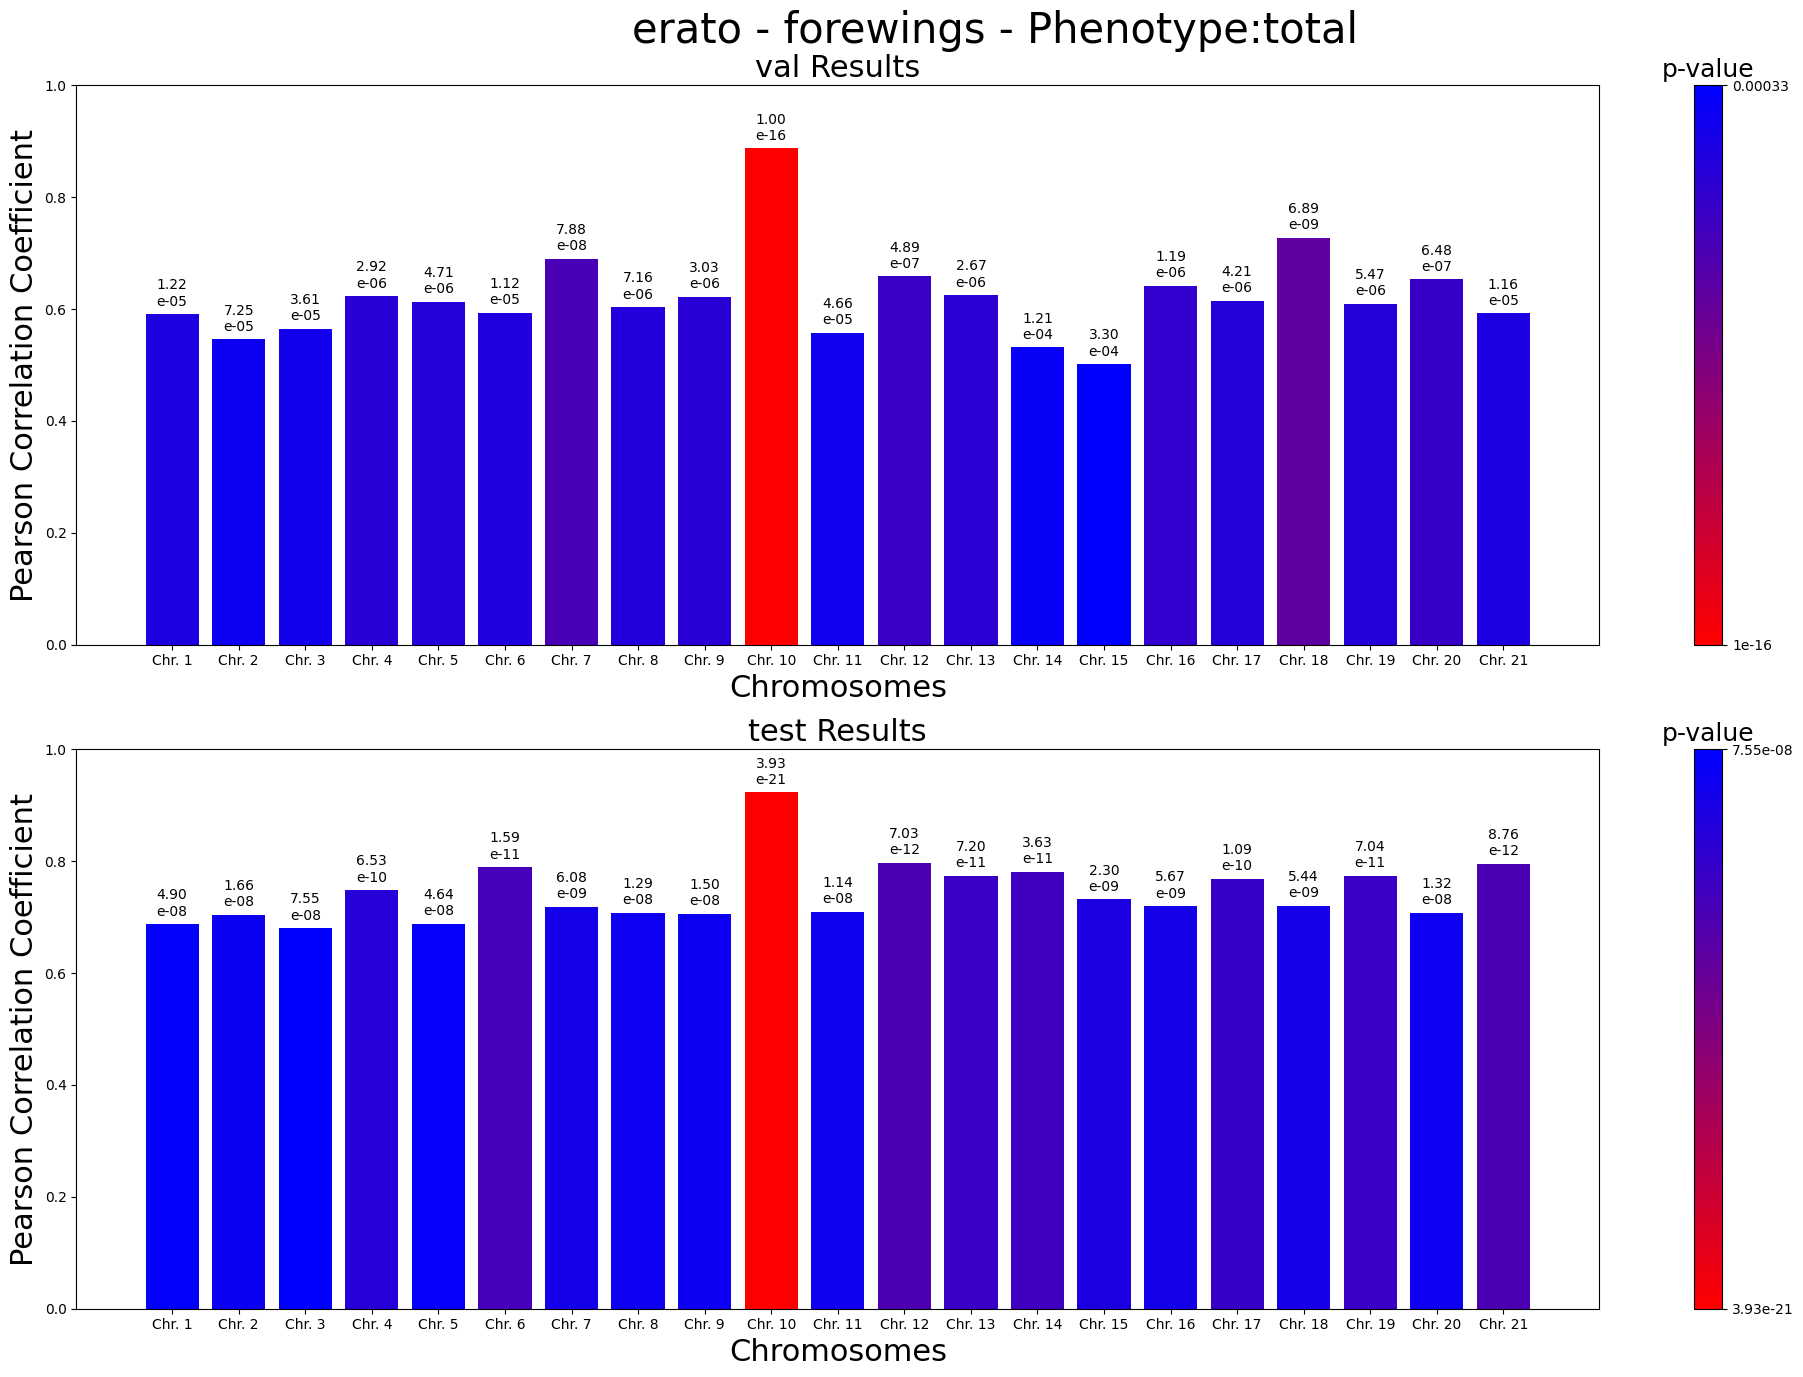

In [8]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm

bar_colors = [
    (1, 0, 0),
    (0, 0, 1),
]  # go from red to blue (significant to least significant)

pos = [0.0, 1.0]
bar_cmap = LinearSegmentedColormap.from_list(
    "custom_colormap", list(zip(pos, bar_colors))
)

fig, axs = plt.subplots(2, 1, figsize=(20, 14))
fig.suptitle(f"{species} - {wing} - Phenotype:{color}", fontsize=30)

chromo_results = np.array(chromo_results)
chromo_pvals = np.array(chromo_pvals)
chromo_labels = [f"Chr. {chr}" for chr in range(1, num_chromosome + 1)]

for pi, phase in enumerate(["val", "test"]):
    val_list = chromo_pvals[:, pi].astype(np.float64)
    normed_vals = LogNorm()(val_list)
    cur_colors = [bar_cmap(pv) for pv in normed_vals]
    bar_plots = axs[pi].bar(chromo_labels, chromo_results[:, pi], color=cur_colors)
    axs[pi].set_title(f"{phase} Results", fontsize=22)
    axs[pi].set_ylim([0, 1])
    axs[pi].set_xlabel("Chromosomes", fontsize=22)
    axs[pi].set_ylabel("Pearson Correlation Coefficient", fontsize=22)

    rects = axs[pi].patches

    for rect, label in zip(rects, chromo_pvals[:, pi]):
        label = "\ne".join(label.split("e"))
        height = rect.get_height()
        axs[pi].text(
            rect.get_x() + rect.get_width() / 2,
            height + 0.01,
            label,
            ha="center",
            va="bottom",
            rotation=0,
        )

    cbar = fig.colorbar(None, ax=axs[pi], cmap=bar_cmap)
    cbar.ax.set_title("p-value", fontsize=18)
    cbar.ax.get_yaxis().set_ticks([1.0, 0.0])
    cbar.ax.get_yaxis().set_ticklabels([val_list.max(), val_list.min()])

fig.tight_layout()

plt.savefig(os.path.join(results_dir / f"genome_summary_{species}_{wing}_{color}.png"))
plt.show()


In [26]:
import os

from tqdm import tqdm
from gtp.tools import calc_pvalue_linear, filter_topk_snps

import pandas as pd
from dash import dcc
import dash_bio as dashbio
import plotly

plot_cache_path = os.path.join(results_dir, f"plot_cache_{species}_{wing}_{color}.csv")

if not os.path.exists(plot_cache_path):
    chromo_labels = [f"Chr. {chr}" for chr in range(1, num_chromosome + 1)]

    top_k_snps_per_chromosome = {"val": [], "test": []}
    plot_data = {"test": [], "val": []}
    for pi, phase in enumerate(["val", "test"]):
        start_pos = 0
        x_mid_points = []
        sig_lines = []
        for ci in tqdm(range(num_chromosome), desc="Plotting Attributions"):
            dset = _, val_data, test_data = load_data(
                PHENOTYPE_FOLDER,
                GENOME_FOLDER,
                DATA_SPLIT_FOLDER,
                ci + 1,
                species,
                wing,
                color,
                out_dims_start_idx=0,
                out_dims=1,
            )
            chromo_data = np.array(attributions[ci][pi])
            num_pos = chromo_data.shape[0]
            X = np.arange(num_pos) + start_pos

            top_k_idx = filter_topk_snps(chromo_data, k=2000)
            top_k_snps_per_chromosome[phase].append(top_k_idx)

            dset = None
            if phase == "val":
                dset = GTP_Dataset(*val_data)
            elif phase == "test":
                dset = GTP_Dataset(*test_data)

            pvals = calc_pvalue_linear(
                np.take(dset.genotype_data, indices=top_k_idx, axis=1),
                dset.phenotype_data[:, 0],
            )
            all_pvals = np.ones(num_pos)
            all_pvals[top_k_idx] = pvals

            for i in range(num_pos):
                plot_data[phase].append(
                    [ci + 1, i + 1, all_pvals[i], f"chr.{ci+1}:{i+1}", ""]
                )

    np.save(
        os.path.join(results_dir, f"top_k_snps_{species}_{wing}_{color}.npy"),
        top_k_snps_per_chromosome,
    )

    df = pd.DataFrame(plot_data["test"], columns=["CHR", "BP", "P", "SNP", "GENE"])

    df.to_csv(plot_cache_path)
else:
    df = pd.read_csv(plot_cache_path)

print("Finished loading/calculating data")
df = df.sort_values(by=["CHR", "P"])
print("Sorted")
dataset = df.groupby('CHR').head(100).reset_index(drop=True)
print(dataset.head(10))
print("Filtered")
fig = dashbio.ManhattanPlot(dataset, title='XYZ Manhattan plot')
fig


Finished loading/calculating data
Sorted
   Unnamed: 0  CHR       BP         P            SNP  GENE
0     1643110    1  1643111  0.000682  chr.1:1643111   NaN
1     1398573    1  1398574  0.001499  chr.1:1398574   NaN
2      230197    1   230198  0.002387   chr.1:230198   NaN
3     1181239    1  1181240  0.002533  chr.1:1181240   NaN
4      651271    1   651272  0.002578   chr.1:651272   NaN
5      230214    1   230215  0.004219   chr.1:230215   NaN
6     1183127    1  1183128  0.004415  chr.1:1183128   NaN
7     1295161    1  1295162  0.004435  chr.1:1295162   NaN
8      308771    1   308772  0.005385   chr.1:308772   NaN
9     1528688    1  1528689  0.005574  chr.1:1528689   NaN
Filtered


In [ ]:
from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, LogNorm
from gtp.tools import calc_pvalue_linear, filter_topk_snps, profile_exe_time

bar_colors = [
    (1, 0, 0),
    (0, 0, 1),
]  # go from red to blue (significant to least significant)

pos = [0.0, 1.0]
bar_cmap = LinearSegmentedColormap.from_list(
    "custom_colormap", list(zip(pos, bar_colors))
)

fig, axs = plt.subplots(2, 1, figsize=(20, 14))
fig.suptitle(f"{species} - {wing} - Phenotype:{color}", fontsize=30)

chromo_labels = [f"Chr. {chr}" for chr in range(1, num_chromosome + 1)]

top_k_snps_per_chromosome = {"val": [], "test": []}
alt_colors = ["blue", "grey"]
for pi, phase in enumerate(["val", "test"]):
    start_pos = 0
    chromo_pvals = np.array(chromo_pvals)
    p_values = chromo_pvals[:, pi].astype(np.float64)
    p_values_normalized = (p_values - p_values.min()) / (
        p_values.max() - p_values.min()
    )
    p_values_normalized = 1 - p_values_normalized
    x_mid_points = []
    sig_lines = []
    for ci in tqdm(range(num_chromosome), desc="Plotting Attributions"):
        dset = _, val_data, test_data = load_data(
            PHENOTYPE_FOLDER,
            GENOME_FOLDER,
            DATA_SPLIT_FOLDER,
            ci + 1,
            species,
            wing,
            color,
            out_dims_start_idx=0,
            out_dims=1,
        )
        chromo_data = np.array(attributions[ci][pi])
        num_pos = chromo_data.shape[0]
        X = np.arange(num_pos) + start_pos

        top_k_idx = filter_topk_snps(chromo_data, k=2000)
        top_k_snps_per_chromosome[phase].append(top_k_idx)

        dset = None
        if phase == "val":
            dset = GTP_Dataset(*val_data)
        elif phase == "test":
            dset = GTP_Dataset(*test_data)

        pvals = calc_pvalue_linear(
            np.take(dset.genotype_data, indices=top_k_idx, axis=1),
            dset.phenotype_data[:, 0],
        )
        all_pvals = np.ones(num_pos)
        all_pvals[top_k_idx] = pvals

        sig_lines.append([start_pos, X[-1], -np.log(0.05 / num_pos)])

        # adjust_val = p_values_normalized[ci]
        # Y = chromo_data
        Y = -np.log(all_pvals)
        start_pos = X[-1]
        bar_plots = axs[pi].scatter(X, Y, alpha=0.5, s=3, color=alt_colors[ci % 2 == 1])
        axs[pi].set_title(f"{phase} Results", fontsize=22)
        axs[pi].set_xlabel("Chromosomes/SNP Position", fontsize=22)
        axs[pi].set_ylabel("Attribution", fontsize=22)
        # axs[pi].axhline(y=-np.log(0.05 / num_pos), color="green")
        mid_point = X[X.shape[0] // 2]
        x_mid_points.append(mid_point)
        axs[pi].text(
            mid_point,
            0,
            f"{p_values[ci]:.1e}",
            ha="center",
            va="bottom",
            rotation=0,
            color="red",
        )

    # for s, e, y in sig_lines:
    #    axs[pi].axhline(y=y, xmin=s/start_pos, xmax=e/start_pos, color='green')
    axs[pi].set_xticks(x_mid_points)
    axs[pi].set_xticklabels(chromo_labels)
    axs[pi].axhline(y=-np.log(1e-8), color="red")
    axs[pi].axhline(y=-np.log(1e-5), color="orange")
    axs[pi].axhline(y=-np.log(0.05 / 2000), color="blue")

fig.tight_layout()

plt.savefig(os.path.join(results_dir, f"genome_detail_{species}_{wing}_{color}.png"))
plt.show()

np.save(
    os.path.join(results_dir, f"top_k_snps_{species}_{wing}_{color}.npy"),
    top_k_snps_per_chromosome,
)

Plotting Attributions:   0%|          | 0/21 [00:00<?, ?it/s]

Plotting Attributions:  62%|██████▏   | 13/21 [04:37<08:02, 60.31s/it]

/tmp/ipykernel_1091874/282410606.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('PuBu_r')


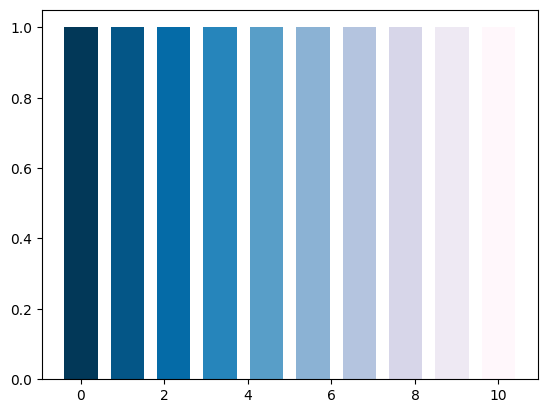

"\n# A low hump with a spike coming out of the top right.  Needs to have\n# z/colour axis on a log scale, so we see both hump and spike. A linear\n# scale only shows the spike.\nZ1 = np.exp(-X**2 - Y**2)\nZ2 = np.exp(-(X * 10)**2 - (Y * 10)**2)\nZ = Z1 + 50 * Z2\n\nfig, ax = plt.subplots(2, 1)\n\npcm = ax[0].pcolor(X, Y, Z,\n                   norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),\n                   cmap='PuBu_r', shading='auto')\nfig.colorbar(pcm, ax=ax[0], extend='max')\n\npcm = ax[1].pcolor(X, Y, Z, cmap='PuBu_r', shading='auto')\nfig.colorbar(pcm, ax=ax[1], extend='max')\nplt.show()\n"

In [7]:
import matplotlib.pyplot as plt

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

cmap = cm.get_cmap("PuBu_r")
log_norm = colors.LogNorm()

X = np.linspace(0, 10, 10)
Y = np.logspace(0, 1e-6, 10, base=1e-20)[::-1]

fig, ax = plt.subplots(1, 1)
ax.bar(X, Y, color=cmap(log_norm(Y)))
plt.show()


"""
# A low hump with a spike coming out of the top right.  Needs to have
# z/colour axis on a log scale, so we see both hump and spike. A linear
# scale only shows the spike.
Z1 = np.exp(-X**2 - Y**2)
Z2 = np.exp(-(X * 10)**2 - (Y * 10)**2)
Z = Z1 + 50 * Z2

fig, ax = plt.subplots(2, 1)

pcm = ax[0].pcolor(X, Y, Z,
                   norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),
                   cmap='PuBu_r', shading='auto')
fig.colorbar(pcm, ax=ax[0], extend='max')

pcm = ax[1].pcolor(X, Y, Z, cmap='PuBu_r', shading='auto')
fig.colorbar(pcm, ax=ax[1], extend='max')
plt.show()
"""